In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import gc

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
traincolumns = ['ip','app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
train = pd.read_csv('datasets/train.csv',skiprows=range(1,149903891), nrows=10000000, usecols = traincolumns)
test = pd.read_csv('datasets/test.csv')
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
train = train.dropna()

In [3]:
def preprocessClicktime(df):
    # Make some new features with click_time column
    df["datetime"] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df['woy']      = df['datetime'].dt.week
    df['day']      = df['datetime'].dt.day
    df['hour']     = df['datetime'].dt.hour
    df['minute']   = df['datetime'].dt.minute
    df['second']   = df['datetime'].dt.second
    return df

In [4]:
train = preprocessClicktime(train)
train = train.drop(['click_time','datetime'],axis=1)
test = preprocessClicktime(test)
test = test.drop(['click_id','click_time','datetime'],axis=1)

y = train['is_attributed']
train = train.drop(['is_attributed'], axis=1)

In [5]:
# Some feature engineering
nrow_train = train.shape[0]
merge = pd.concat([train, test])
del train, test
gc.collect()

276

In [6]:
# Count the number of clicks by ip
ip_count = merge.groupby('ip')['app'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge.drop('ip', axis=1, inplace=True)

In [7]:
train = merge[:nrow_train]
test = merge[nrow_train:]
del merge
gc.collect()

7

In [8]:
params = {
    'eta': 0.3, # learning rate
    'tree_method': "auto", 
    'max_depth': 4, 
    'subsample': 0.8, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':9,
    'eval_metric': 'auc', 
    'random_state': 99, 
    'silent': True,
    "tree_method":'gpu_hist',
    "predictor":'gpu_predictor',
}
          
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 300, watchlist, maximize=True, early_stopping_rounds = 50, verbose_eval=10)

[0]	train-auc:0.878924	valid-auc:0.877071
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.945303	valid-auc:0.942712
[20]	train-auc:0.95201	valid-auc:0.948047
[30]	train-auc:0.956964	valid-auc:0.952498
[40]	train-auc:0.960162	valid-auc:0.955552
[50]	train-auc:0.961934	valid-auc:0.957075
[60]	train-auc:0.962866	valid-auc:0.957468
[70]	train-auc:0.964122	valid-auc:0.958385
[80]	train-auc:0.964983	valid-auc:0.959032
[90]	train-auc:0.965416	valid-auc:0.959208
[100]	train-auc:0.96593	valid-auc:0.959558
[110]	train-auc:0.966492	valid-auc:0.960084
[120]	train-auc:0.966938	valid-auc:0.960267
[130]	train-auc:0.967369	valid-auc:0.960418
[140]	train-auc:0.967856	valid-auc:0.960282
[150]	train-auc:0.96821	valid-auc:0.960414
[160]	train-auc:0.968483	valid-auc:0.960584
[170]	train-auc:0.968771	valid-auc:0.960558
Stopping. Best iteration:
[126]	train-auc:0.967209	valid-auc:0.960621



In [9]:
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub6.csv',index=False) # LB score 0.9633

In [10]:
model.get_score()

{'app': 532,
 'clicks_by_ip': 484,
 'device': 191,
 'channel': 532,
 'os': 365,
 'second': 162,
 'hour': 97,
 'minute': 215,
 'woy': 2,
 'dow': 2,
 'day': 1}

In [11]:
model.best_score

0.960621

In [12]:
model.save_model('0002.model')

In [41]:
model = xgb.Booster({'nthread': 4})  # init model
model.load_model('0002.model')  # load data

In [42]:
model.

AttributeError: 'Booster' object has no attribute 'best_score'

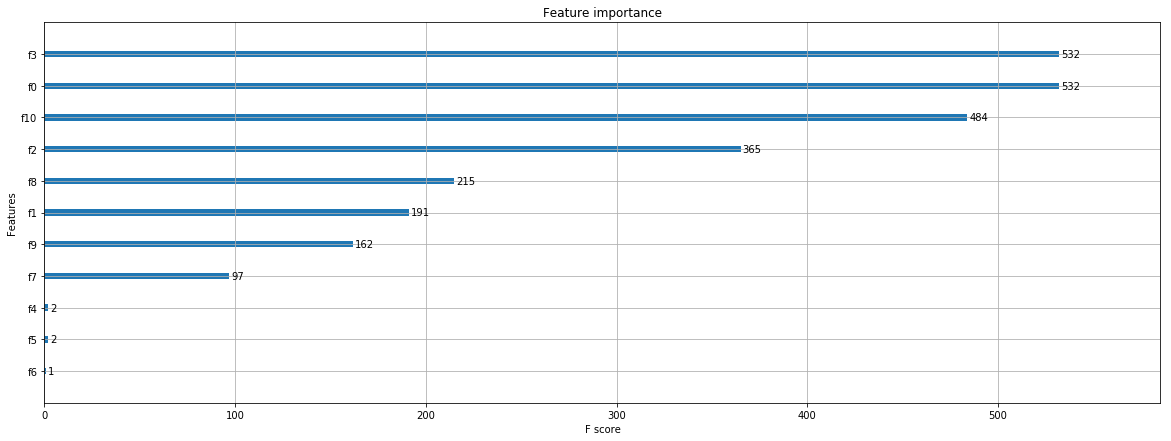

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 7))
xgb.plot_importance(model, ax=ax)

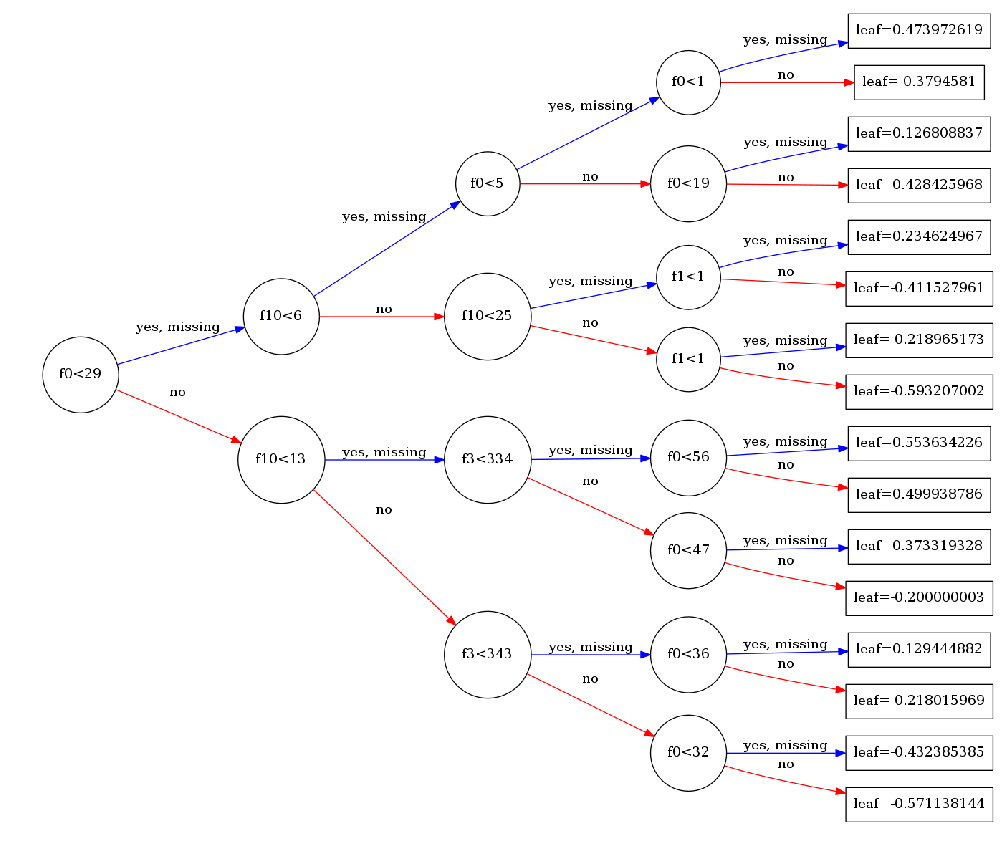

In [39]:
fig, ax = plt.subplots(figsize=(20, 15))
xgb.plot_tree(model, rankdir='LR', ax=ax)